In [1]:

# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

## Part 1 (50 points): Fuel Consumption → Horsepower Prediction

In [2]:
# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "FuelEconomy.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())


Shape: (100, 2)

Columns:
['Horse Power', 'Fuel Economy (MPG)']


,Horse Power,Fuel Economy (MPG)
0,118.770799,29.344195
1,176.326567,24.695934
2,219.262465,23.952010
3,187.310009,23.384546
4,218.594340,23.426739



Summary statistics:


,Horse Power,Fuel Economy (MPG)
count,100.000000,100.000000
mean,213.676190,23.178501
std,62.061726,4.701666
min,50.000000,10.000000
25%,174.996514,20.439516
50%,218.928402,23.143192
75%,251.706476,26.089933
max,350.000000,35.000000



Missing values per column:


Horse Power           0
Fuel Economy (MPG)    0
dtype: int64

In [3]:
# Function that randomly splits the data set into 70% training and 30% testing.
def split_data(X, y, test_size=0.30, random_state=42):
    """70/30 random train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [4]:
# ============================================================
# Utility functions
# ============================================================

TARGET_COL = "Horse Power"
X_COL = "Fuel Economy (MPG)"

def prepare_xy(df_in, target_col=TARGET_COL):
    """Drop missing rows, split into X and y."""
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

def compute_metrics(y_true, y_pred):
    """Return MSE, MAE, R^2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

def _get_linear_parts(model, input_feature_names):
    """Extract (intercept, coefficients, feature_names) from either:
       - LinearRegression
       - Pipeline(PolynomialFeatures -> LinearRegression)
    """
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

def print_fitted_equation(model, input_feature_names, target_name=TARGET_COL, top_k_terms=15):
    """Print a readable fitted equation.

    For polynomial models, the number of terms can become very large,
    so we print only the TOP-K terms by absolute coefficient magnitude.
    """
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)

    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    """Scatter plot of Actual vs Predicted values on the TEST set.

    We plot both series against a sample index, using:
    - Actual: blue circles
    - Predicted: red x's

    If test set is large, we randomly sample up to max_points points for readability.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel(X_COL)
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

def run_models_and_evaluate(df_in, scenario_name, degrees=(1, 2, 3, 4),
                            target_col=TARGET_COL, test_size=0.30, random_state=42,
                            show_equation=True, show_plots=True, top_k_terms=15):
    """Train/evaluate linear (deg=1) + polynomial regression models.

    Returns a DataFrame of metrics.
    Also prints fitted equations and scatter plots (test set) for each model.
    """
    X, y = prepare_xy(df_in, target_col=target_col)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train)
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)



Scenario: Predicting Horsepower
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Horse Power = 500.3638 (-12.3785) * Fuel Economy (MPG)


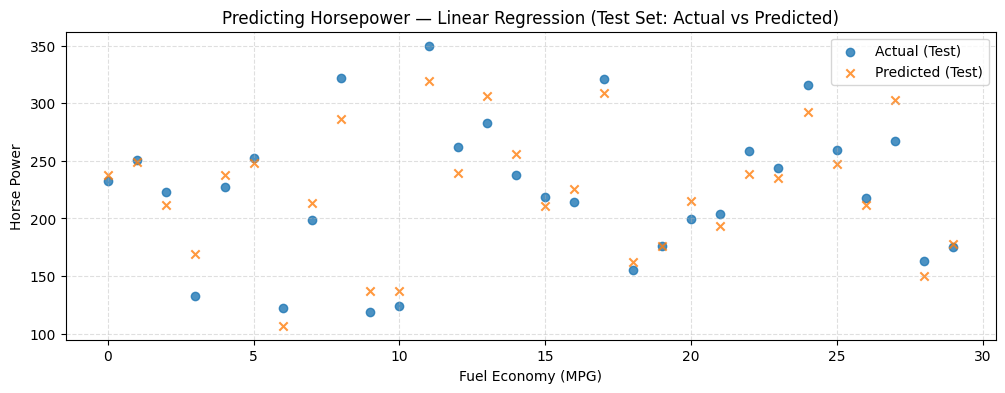


Scenario: Predicting Horsepower
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 457.3741 (-8.5915) * Fuel Economy (MPG) (-0.0800) * Fuel Economy (MPG)^2


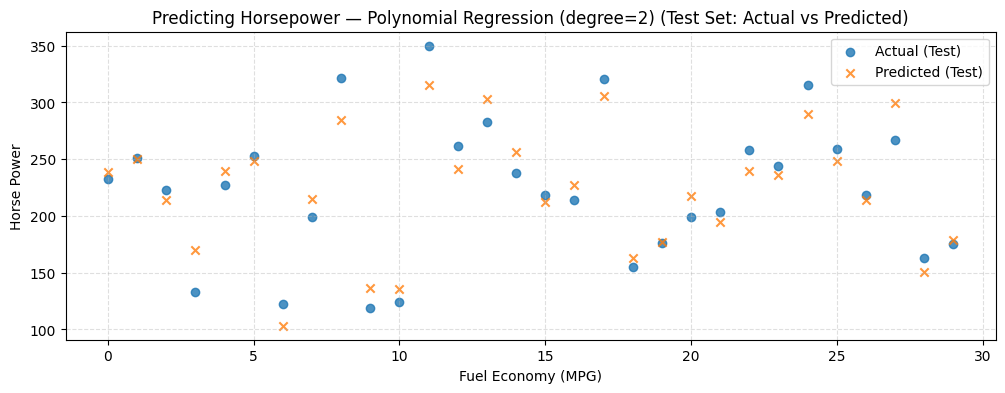


Scenario: Predicting Horsepower
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 355.6514 (+6.0952) * Fuel Economy (MPG) (-0.7505) * Fuel Economy (MPG)^2 (+0.0097) * Fuel Economy (MPG)^3


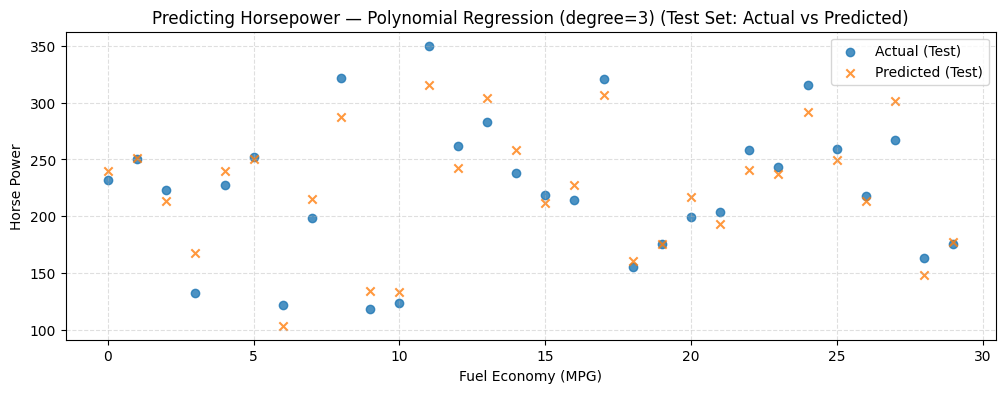


Scenario: Predicting Horsepower
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 90.1049 (+61.1736) * Fuel Economy (MPG) (-4.7743) * Fuel Economy (MPG)^2 (+0.1339) * Fuel Economy (MPG)^3 (-0.0014) * Fuel Economy (MPG)^4


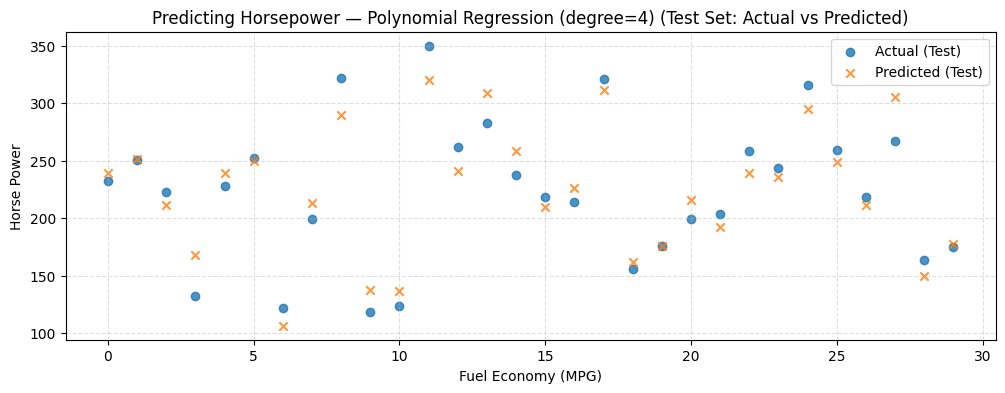

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Predicting Horsepower,Linear Regression,357.699180,16.061689,0.906320,318.561087,14.940628,0.912561,70,30
1,Predicting Horsepower,Polynomial Regression (degree=2),350.879731,15.995824,0.908106,331.105434,15.148330,0.909118,70,30
2,Predicting Horsepower,Polynomial Regression (degree=3),345.108668,15.746762,0.909618,318.404012,14.764973,0.912604,70,30
3,Predicting Horsepower,Polynomial Regression (degree=4),339.700171,15.508465,0.911034,313.798757,14.735471,0.913868,70,30


In [5]:
results_A = run_models_and_evaluate(
    df,
    scenario_name="Predicting Horsepower",
    degrees=(1, 2, 3, 4),
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results_A)

## Discussion and Interpretation

### (1) Best Model Selection (Test Performance)
#### Which model (**Linear / Poly-2 / Poly-3 / Poly-4**) performs best on the **test set** and why?  

The model that performed the best on the test set was the Polynomial Regression with degree 4. The model had the highest R² with a value of 0.913868, meaning that 91.3868% of the variance in the Horse Power variable is accounted for by the model. With the highest test R², this model was able to best capture the data's patterns and make accurate predictions, out of all of the models computed. 

---

### (2) Effect of Polynomial Degree
#### Does increasing the polynomial degree always improve **performance**? If not, explain what you observe. 

In this case, increasing the polynomial degree always improved the test performance. Using the Test R² as our metric to draw a trend, we can see that the Test R² increased everytime the degree of the polynomial regression increased. The Test R² for a 2nd degree polynomial regression was 0.909118. The Test R² for a 3rd degree polynomial regression was 0.912604, which is an increase of 0.003486 from the 2nd degree. The Test R² for a 4th degree polynomial regression was 0.913868, which is an increase of 0.001264 from the 3rd degree. With this data, it is clear that the Test R² always increases as the degree of the polynomial degression increases. As a result, we can conclude that increasing the polynomial degree always improves the model's performance for predicting horsepower based on fuel economy (mpg).

## Part 2 (50 points): Weather → Daily Electricity Consumption Prediction

In [6]:
# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "electricity_consumption_based_weather_dataset.csv"
df = pd.read_csv(DATA_PATH).drop(columns=["date"])            # get rid of the date column, as we will not be evaluating its effect on daily consumption

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())

Shape: (1433, 5)

Columns:
['AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']


,AWND,PRCP,TMAX,TMIN,daily_consumption
0,2.5,0.0,10.6,5.0,1209.176
1,2.6,0.0,13.3,5.6,3390.460
2,2.4,0.0,15.0,6.7,2203.826
3,2.4,0.0,7.2,2.2,1666.194
4,2.4,0.0,7.2,1.1,2225.748



Summary statistics:


,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
mean,2.642313,3.800488,17.187509,9.141242,1561.078061
std,1.140021,10.973436,10.136415,9.028417,606.819667
min,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,3.300000,1.300000,26.100000,17.200000,1893.608000
max,10.200000,192.300000,39.400000,27.200000,4773.386000



Missing values per column:


AWND                 15
PRCP                  0
TMAX                  0
TMIN                  0
daily_consumption     0
dtype: int64


Scenario: Weather
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2045.7562 (-17.2734) * TMAX (-17.0839) * TMIN (-7.5783) * AWND (-3.3603) * PRCP


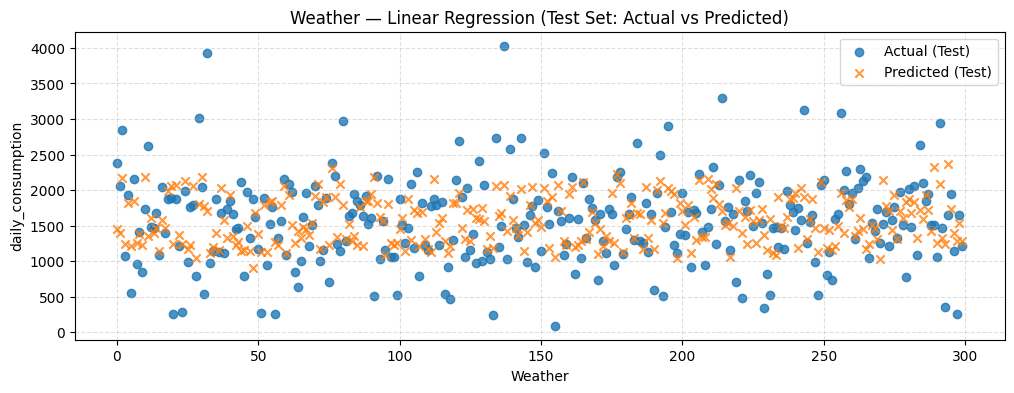


Scenario: Weather
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2037.4142 (+165.5267) * AWND (-60.9740) * TMAX (-27.8962) * AWND^2 (+26.8325) * TMIN (-10.4820) * PRCP (-2.6130) * TMAX TMIN (-1.9368) * PRCP TMIN (+1.8505) * TMAX^2 (+1.5725) * PRCP TMAX (+1.2309) * AWND PRCP (+1.1693) * AWND TMIN (-1.0760) * AWND TMAX (+0.2939) * TMIN^2 (-0.0545) * PRCP^2


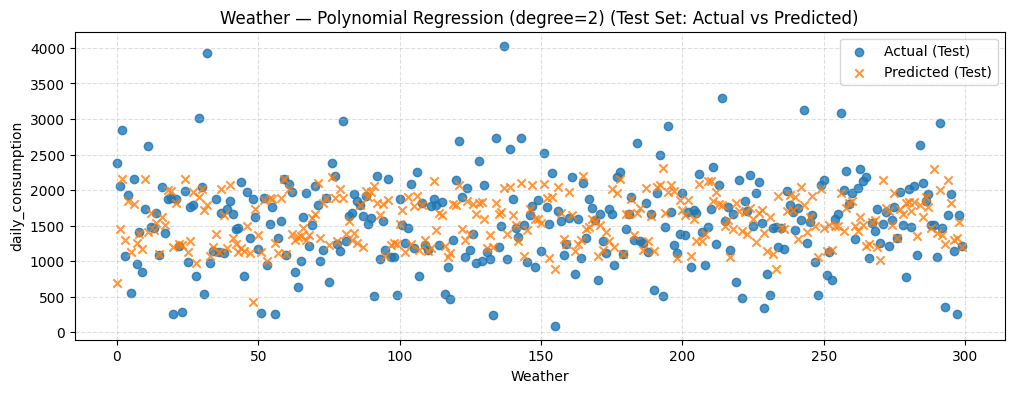


Scenario: Weather
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1405.7630 (+509.9634) * AWND (-140.8094) * AWND^2 (+67.4216) * TMAX (-63.7983) * TMIN (+25.0565) * TMAX TMIN (-20.2281) * AWND TMIN (-13.9648) * TMIN^2 (-13.1044) * TMAX^2 (+9.3010) * PRCP (+7.8406) * AWND^3 (-4.9294) * AWND PRCP (+3.8559) * AWND^2 TMAX (+3.4853) * AWND TMAX TMIN (+2.2711) * AWND TMAX (-1.8669) * TMAX^2 TMIN
(Showing top 15 terms out of 34 total terms.)


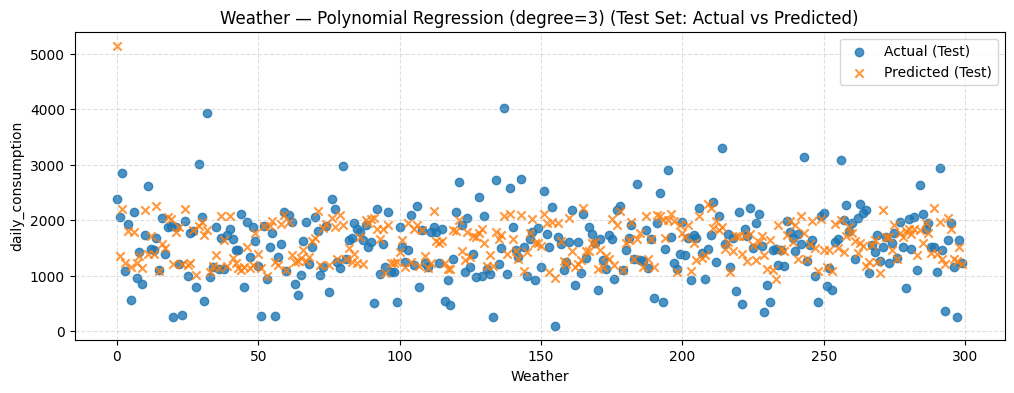


Scenario: Weather
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1437.2413 (-416.4509) * AWND (-386.5721) * TMIN (+312.1157) * TMAX (+245.1996) * AWND^2 (+175.5947) * TMAX TMIN (+144.1717) * AWND TMAX (-110.1963) * AWND TMIN (-89.7729) * TMIN^2 (-83.0902) * AWND PRCP (-82.3475) * TMAX^2 (-63.0753) * AWND^2 TMAX (+58.6639) * AWND^2 TMIN (-41.9050) * AWND^3 (+26.1746) * AWND^2 PRCP (-25.1428) * AWND TMAX TMIN
(Showing top 15 terms out of 69 total terms.)


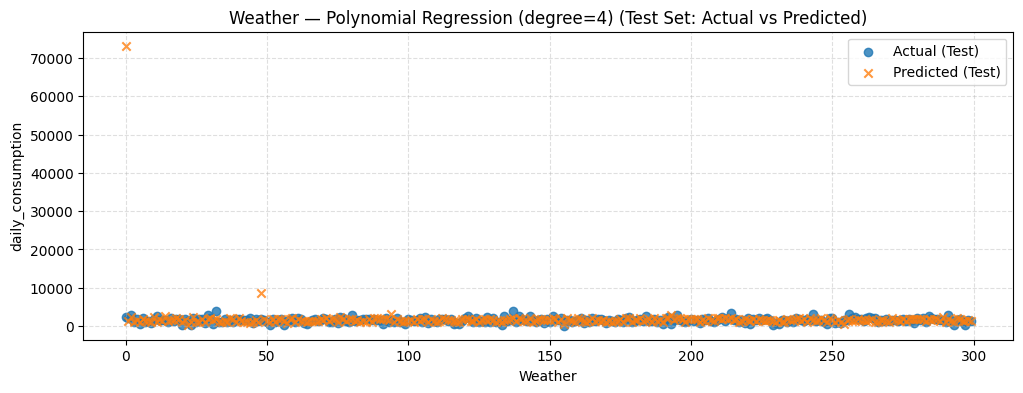

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Weather,Linear Regression,272403.396174,384.465016,0.276000,2.481258e+05,375.404537,0.299333,992,426
1,Weather,Polynomial Regression (degree=2),264765.769932,379.648753,0.296300,2.552685e+05,379.039083,0.279163,992,426
2,Weather,Polynomial Regression (degree=3),259249.534870,375.952901,0.310961,2.656237e+05,385.235167,0.249922,992,426
3,Weather,Polynomial Regression (degree=4),251909.339001,372.116566,0.330470,1.215149e+07,578.642201,-33.313844,992,426


In [7]:
TARGET_COL = 'daily_consumption'
X_COL = "Weather"

results = run_models_and_evaluate(
    df,
    scenario_name="Weather",
    degrees=(1, 2, 3, 4),
    target_col="daily_consumption",
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

display(results)

## Discussion and Interpretation

### (1) Best Model Selection (Test Performance)
#### Which model (**Linear / Poly-2 / Poly-3 / Poly-4**) generalizes best, and what does that tell you about the relationship between weather and electricity usage? 

The model that performed the best on the test set was the Linear Regression. The model had the highest R² with a value of 0.299333, meaning that 29.9333% of the variance in the Electricity usage variable is accounted for by the model. With the highest test R², this model was able to best capture the data's patterns and make accurate predictions, out of all of the models computed. Therefore, this reveals that the relationship between weather and electricity usage is better modeled mathematically as linear than polynomial. 

---

### (2) Effect of Polynomial Models
#### Do polynomial models improve the fit compared to linear regression? If yes, why might electricity consumption have nonlinear dependence on weather?

In this case, polynomial models did not improve the fit compared to linear regression. Using the Test R² as our metric to draw a trend, we can see that neither of the Test R² for the polynomial models had a higher value than that of the Linear Regression's. As a result, we can conclude that polynomial models do not improve the fit, as their respective Test R²s indicate that they do a worse job capturing the variance and trends.

---

### (3) Effect of Increasing Polynomial Degree
#### If higher-degree models perform worse on the test set, explain this behavior using evidence from metrics. 

From the data, we can see that Test R² tends to decrease as the degree for the polynomial regression increases. The Test R² for a 2nd degree polynomial regression was 0.279163. The Test R² for a 3rd degree polynomial regression was 0.249922, which is an decrease of 0.029241 from the 2nd degree. The Test R² for a 4th degree polynomial regression was -33.313844, which is an decrease of 33.563766 from the 3rd degree. As a result, we can conclude that increasing the polynomial degree worsens the model's performance for predicting electricity usage.

---

### (4) Test Performance
#### If none of the models achieve good test performance, provide at least two reasons supported by your outputs (e.g., limited feature set, high noise, unmodeled drivers such as occupancy/behavior, seasonal effects).

Since all of the models have a Test R² < 0.30, none of them achieve a good test performance. For the models of linear regression and polynomial regression of degrees 2 and 3, the Train R² is slightly greater than Test R². Both R²s are quite small ( < 0.32), indicating that the models are underfitting the data. For the polynomial regression of degree 4, however, the Test R² is incredibly lower than the Train R² (by nearly 34 units). This reveals that the model overfits the training data, as its performance is so poor on the testing data. Essentially, linear and polynomial regressions of degrees 2 and 3 are simply not complex enough to capture the trend of the data. On the other hand, the polynomial regression of degree 4 is too complex for the data, capturing the training data trends too well and generalizing poorly to testing data. 

I believe that another valid reason for the test performance could be correlated with the untracked seasonal effects on daily consumption. In the winter, especially, is when energy consumption tends to peak due to the constant heating and people leaning towards staying indoors. So we should see a peak around the wintertime and then a decrease as we move away from the season. 